In [ ]:
#Conecta a sua conta do Drive para pegar os .pickle nos proximos blocos

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import tree
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

def KNNClassifier(X_train, y_train, X_test, y_test, k = 1, distancia = 'euclidean'):
        #acertos(treinamento_normalizado, teste_normalizado, k, distancia)
        from sklearn.metrics import classification_report
        neigh = KNeighborsClassifier(n_neighbors=k, metric=distancia)
        neigh.fit(X_train, y_train)
        #return (neigh.score(X_test, y_test))
        return f1_score(y_test, neigh.predict(X_test), average='weighted')
        #return classification_report(y_test, neigh.predict(X_test))
        
def SVMWithGridSearch(X_train, y_train, X_test, y_test, ker = 'rbf', normalizacao = 'min-max'):
    C_range = 2. ** np.arange(-5,15,2)
    gamma_range = 2. ** np.arange(3,-15,-2)
    #k = [ 'rbf']
    # instancia o classificador, gerando probabilidades
    srv = svm.SVC(probability=True, kernel=ker)

    if normalizacao == 'min-max':
      ss = MinMaxScaler() #Cria o Normalizador
    else:
      ss = StandardScaler()
    pipeline = Pipeline([ ('scaler', ss), ('svm', srv) ])
#        
    param_grid = {
        'svm__C' : C_range,
        'svm__gamma' : gamma_range
    }
#        
#        # faz a busca
    grid = GridSearchCV(pipeline, param_grid, n_jobs=-1, verbose=False)
    grid.fit(X_train, y_train)
#        
#        # recupera o melhor modelo
    model = grid.best_estimator_
    #return f1_score(X_test, y_test, average='weighted')
    return f1_score(y_test, grid.predict(X_test), average='weighted'), grid.best_estimator_
    #return (grid.score(X_test, y_test))
    #return classification_report(y_test, model.predict(X_test))
#        

def MLP(X_train, y_train, X_test, y_test, normalizacao = 'min-max', confusion = False):
    if normalizacao == 'min-max':
      scaler = MinMaxScaler() #Cria o Normalizador
    else:
      scaler = StandardScaler()

    parameter_space = {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
    }
    #MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 100, 50), random_state=0)

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    mlp = MLPClassifier(max_iter=100)

    #clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(500, 500, 500, 500), random_state=1)
    #clf.fit(X_train, y_train)

    clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
    clf.fit(X_train, y_train)
    if confusion == True:
      import seaborn as sn
      import pandas as pd
      import matplotlib.pyplot as plt
      result = (confusion_matrix(y_test, clf.predict(X_test)))
      print("result C Matrix")
      print(result)
      plt.figure(figsize = (10,7))
      sn.heatmap(result, annot=True)

    return f1_score(y_test, clf.predict(X_test), average='weighted'), clf.best_estimator_

def RandomForestClassifiers(X_train, y_train, X_test, y_test, normalizacao = 'min-max'):

    if normalizacao == 'min-max':
      scaler = MinMaxScaler() #Cria o Normalizador
    else:
      scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    parametros = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [100, 200],
        }
    rf = RandomForestClassifier()

    clf = GridSearchCV(estimator=rf, param_grid=parametros, cv= 5, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    return f1_score(y_test, clf.predict(X_test), average='weighted'), clf.best_estimator_

def decisionTree(X_train, y_train, X_test, y_test):
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    return classification_report(y_test, predict)
    #tree.plot_tree(clf)


In [ ]:
best_all_value = [0,'']
for deepfeature in ['inception', 'mobilenet', 'resnet', 'vgg16', 'vgg19', 'xception']:
  print("\n===========================================")
  print("--------DeepFeature: ", deepfeature)
  file = open('/content/drive/MyDrive/features/dataset_'+deepfeature+'.pickle', 'rb')
  data = pickle.load(file)

  X = data[:, 0 : -1]
  y = data[:,-1]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  #['ACURACIA', 'DISTANCIA', 'K', 'NORMALIZACAO', 'DEEP_FEATURE']
  best_value_knn = [0,'',0, '', '']

  #acuracia, Normalizacao, kernel, best estimator, deep_feature
  best_value_svm = [0,'','', 0, '']

  #acuracia, normalizacao, best_estimator, deep_feature
  best_value_mlp = [0,'', 0, '']

  #acuracia, normalizacao, best_estimator, deep_feature
  best_value_rf = [0,'', 0, '']

  for normalizacao in ['min-max', 'z-score']:
    print("Tipo de Normalização: ", normalizacao)

    '''Radom Forest- '''
    '''     '''
    print("-----------------------------------------------------RFOREST")
    acc_rf, best = RandomForestClassifiers(X_train, y_train, X_test, y_test, normalizacao)
    print("ACC: ", acc_rf)

    if acc_rf > best_value_rf[0]:
      best_value_rf[0] = acc_rf
      best_value_rf[1] = normalizacao
      best_value_rf[2] = best
      best_value_rf[3] = deepfeature

    if acc_rf > best_all_value[0]:
      best_all_value[0] = acc_rf
      best_all_value[1] = best_value_rf
      best_all_value[2] = "RFOREST"


    '''MLP- '''
    '''     '''
    print("-----------------------------------------------------MLP")
    acc_mlp, best = MLP(X_train, y_train, X_test, y_test, normalizacao)
    print("ACC: ", acc_mlp)

    if acc_mlp > best_value_mlp[0]:
      best_value_mlp[0] = acc_mlp
      best_value_mlp[1] = normalizacao
      best_value_mlp[2] = best
      best_value_mlp[3] = deepfeature

    if acc_mlp > best_all_value[0]:
      best_all_value[0] = acc_mlp
      best_all_value[1] = best_value_mlp
      best_all_value[2] = "MLP"

    ''' SVM ----- '''
    '''           '''
    print("-----------------------------------------------------SVM")
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
      acc_svm, best = SVMWithGridSearch(X_train, y_train, X_test, y_test, kernel, normalizacao)
      print("Kernel: ", kernel, "ACC: ", acc_svm)
      if acc_svm > best_value_svm[0]:
        best_value_svm[0] = acc_svm
        best_value_svm[1] = normalizacao
        best_value_svm[2] = kernel
        best_value_svm[3] = best
        best_value_svm[4] = deepfeature

      if acc_svm > best_all_value[0]:
        best_all_value[0] = acc_svm
        best_all_value[1] = best_value_svm
        best_all_value[2] = "SVM"

    ''' KNN ----- '''
    '''           '''
    print("-----------------------------------------------------KNN")
    if normalizacao == 'min-max':
      ss = MinMaxScaler() #Cria o Normalizador
    else:
      ss = StandardScaler()

    ss.fit(X_train)                
    X_train_normalizado = ss.transform(X_train) #Aplica a normalização
    X_test_normalizado = ss.transform(X_test) #Aplica a normalização

    for distancia in ['euclidean','manhattan', 'minkowski', 'chebyshev']:
      print("\nDistancia:", distancia)

      for k in [1,3,5,7,9,11,13,15,17,19]:
        acc = KNNClassifier(X_train_normalizado, y_train, X_test_normalizado, y_test, k, distancia)
        print("K: ",k,"Acc:",acc)
        if acc > best_value_knn[0]:
          best_value_knn[0] = acc
          best_value_knn[1] = distancia
          best_value_knn[2] = k
          best_value_knn[3] = normalizacao
          best_value_knn[4] = deepfeature

        if acc > best_all_value[0]:
          best_all_value[0] = acc
          best_all_value[1] = best_value_knn
          best_all_value[2] = "KNN"

  print("\n=-----BEST VALUES--DO--KNN---------------=")        
  print("ACC: ",best_value_knn[0])
  print("Distancia: ",best_value_knn[1])
  print("K: ",best_value_knn[2])
  print("Normalizacao: ",best_value_knn[3])
  print("=-----------------------------------------=")


  print("\n=-----BEST VALUES--DO--SVM---------------=")        
  print("ACC: ", best_value_svm[0])
  print("Normalizacao: ", best_value_svm[1])
  print("Kernel: ", best_value_svm[2])
  print("Best Parametros: ", best_value_svm[3])
  print("=-----------------------------------------=")


  print("\n=-----BEST VALUES--DO--MLP---------------=")        
  print("ACC: ", best_value_mlp[0])
  print("Normalizacao: ", best_value_mlp[1])
  print("Best Parametros: ", best_value_mlp[2])
  print("=-----------------------------------------=")


  print("\n=-----BEST VALUES--DO--RFOREST---------------=")        
  print("ACC: ", best_value_rf[0])
  print("Normalizacao: ", best_value_rf[1])
  print("Best Parametros: ", best_value_rf[2])
  print("=-----------------------------------------=")

  print("===========================================\n\n")



  '''Decision Tree- '''
  '''               '''
  #Código do Decision Tree

print(best_all_value)


--------DeepFeature:  resnet
Tipo de Normalização:  z-score
-----------------------------------------------------MLP
result C Matrix
[[23  5]
 [ 4 22]]
ACC:  0.833390508862207


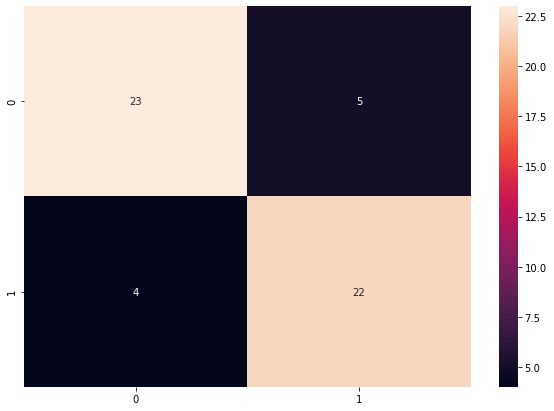

In [ ]:
'''

O melhor de todos

+------------------------------------------------------------------------
|O melhor de TODOS!!!!!
|
|ExtractionFeature: RESNET
|ACC: 0.9443871115697741
|Classificador: MLP
|Normalização: z-score
|Parametros: MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 100, 50), random_state=0)
+------------------------------------------------------------------------

'''

def MLP(X_train, y_train, X_test, y_test, normalizacao = 'min-max', confusion = False):
    if normalizacao == 'min-max':
      scaler = MinMaxScaler() #Cria o Normalizador
    else:
      scaler = StandardScaler()

    parameter_space = {
        'hidden_layer_sizes': [(50,100,50)],
        'activation': ['tanh'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
    }
    #MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 100, 50), random_state=0)

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    mlp = MLPClassifier(max_iter=100)

    #clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(500, 500, 500, 500), random_state=1)
    #clf.fit(X_train, y_train)

    clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
    clf.fit(X_train, y_train)
    if confusion == True:
      import seaborn as sn
      import pandas as pd
      import matplotlib.pyplot as plt
      result = (confusion_matrix(y_test, clf.predict(X_test)))
      print("result C Matrix")
      print(result)
      plt.figure(figsize = (10,7))
      sn.heatmap(result, annot=True)

    return f1_score(y_test, clf.predict(X_test), average='weighted'), clf.best_estimator_






for deepfeature in ['resnet']:
  print("\n===========================================")
  print("--------DeepFeature: ", deepfeature)
  file = open('/content/drive/MyDrive/features/dataset_'+deepfeature+'.pickle', 'rb')
  data = pickle.load(file)

  X = data[:, 0 : -1]
  y = data[:,-1]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  #acuracia, normalizacao, best_estimator, deep_feature
  best_value_mlp = [0,'', 0, '']

  for normalizacao in ['z-score']:
    print("Tipo de Normalização: ", normalizacao)

    '''MLP- '''
    '''     '''
    print("-----------------------------------------------------MLP")
    acc_mlp, best = MLP(X_train, y_train, X_test, y_test, normalizacao, True)
    print("ACC: ", acc_mlp)
